# Performing Aperture Photometry on a Single Source and Calibrating to Pan-STARRS1 Magnitudes

In [1]:
import sys
import astropy.units as u
import astropy.coordinates as coord

from astropy.io import fits
from IPython.display import display, Markdown

# SDSS-V Tools
sys.path.insert(1, '../lco_phot')
from lco_redux import lco_redux

# Define Image to Process and Target/Comp Coordinates

In [2]:
image_dir = "../data"
image_name = f"{image_dir}/elp1m008-fa05-20210704-0113-e91.fits.fz"

# Target Coordinates
target_coord = coord.SkyCoord(
    ra=24.77665*u.deg,
    dec=52.76009*u.deg,
    frame='icrs'
)

# Comparison Star Coordinates (only used for initial FWHM estimate)
comp_coord = coord.SkyCoord(
    ra=24.7728034*u.deg,
    dec=52.7617258*u.deg,
    frame='icrs'
)

# Run LCO Redux

Performing Target Pan-STARRS Query...Complete



Calculating Centroids...100%|████████████████████████████████████████| 1/1 [00:00<00:00, 418.34it/s]                                             



Identifying Sources in LCO Image...
1963 Sources Identified

Loading Pan-STARRS Query...



Matching Objects to PS1...100%|████████████████████████████████████████| 1963/1963 [00:01<00:00, 1023.58it/s]                                    



1757 out of 1963 Objects Matched



Calculating Centroids...100%|████████████████████████████████████████| 1757/1757 [00:05<00:00, 332.64it/s]                                       




Determining Aperture Size from FWHM...
Aperture Radius (Pixels) = 4.19
Aperture Radius (arcsec) = 1.63


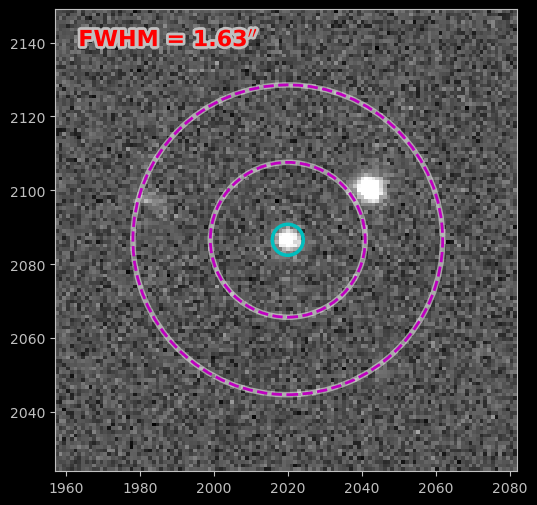


Performing Aperture Photometry...
 Median Background: 292.366 c/pix
Average Background: 296.263 c/pix

Finished! 



|    |     mjd |        bjd | date       | time         | filter   |   texp |     mag |    magerr |      Zp |      Zp_err |      cterm |   cterm_err |   Nfit |      sn |   fwhm |   aper_rad (pix) |   airmass | site_id   | telescope   |   temp |   humidity |   wind |   sky |   moonfrac |   moondist |   moonalt |
|---:|--------:|-----------:|:-----------|:-------------|:---------|-------:|--------:|----------:|--------:|------------:|-----------:|------------:|-------:|--------:|-------:|-----------------:|----------:|:----------|:------------|-------:|-----------:|-------:|------:|-----------:|-----------:|----------:|
|  0 | 59400.4 | 2.4594e+06 | 2021-07-05 | 10:38:18.267 | gp       | 119.98 | 18.4108 | 0.0251427 | 3.01575 | 4.29238e-06 | -0.0829924 | 1.01016e-05 |   1627 | 43.3044 |   1.63 |          4.19023 |    1.2987 | elp       | 1m0-08      |     68 |       64.1 |  7.425 | 21.35 |   0.180544 |    41.8201 |   23.2218 |

In [3]:
# Constraints used for the Pan-STARRS1 queries
constraints = {
    'ng.gt':3,
    'nr.gt':3,
    'ni.gt':3,
    'nDetections.gt':11,
    'gMeanPSFMag.gt':14.0,
    'rMeanPSFMag.gt':14.0,
    'iMeanPSFMag.gt':14.0
}

phot_dat = lco_redux(
    image_name,
    target_coord,
    comp_coord,
    # Aperture size params, in units of factors times the FWHM
    r_aperture=1.0,
    r_inner_annulus=5.0,
    r_outer_annulus=10.0,
    # "Target query" refers to Pan-STARRS1 query used
    # to get PS1 magnitudes for the provided source
    target_query_constraints=constraints,
    target_query_save=False,
    target_query_dir="../data/", 
    target_query_name="ps_target.csv",
    target_query_format="csv",
    # "Full query" refers to a PS1 query that covers
    # the whole image FOV, used to calibrate photometry
    full_query_constraints=constraints,
    full_query_save=True,
    full_query_dir="../data/", 
    full_query_name="ps_query.csv",
    full_query_format="csv",
    # Whether to save photometry results to file
    phot_save=True,
    phot_dir="../data/",
    phot_name=None, # Default = <image_name>_phot.csv
    # WHether to plot cutout
    plot_cutout=True,
    plot_save=True,
    plot_dir="../data/",
    plot_name=None, # Default = <image_name>_cutout.png
    # Whether to print out results
    verbose=False
)

# Display result
display(Markdown(phot_dat.to_markdown()))